In [2]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib, time

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

## 2D dataset
### Binary classification

In [3]:
import mylibrary.nnlib as tnn

In [4]:
# #http://notmatthancock.github.io/software/dataset2d/

# # data_path = "./data/noisy_moon_2d_2c.csv"
# data_path = "./data/noisy_linear_2d_2c.csv"
# # data_path = "./data/clean_circular_2d_2c.csv"


# df = pd.read_csv(data_path)
# # print(df.columns)
# x1 = np.array(df['# x'], dtype=float)/200
# x2 = np.array(df['y'], dtype=float)/200
# y = np.array(df['label'], dtype=int)

In [5]:
def twospirals(n_points, noise=.5 , ang=720):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * ang *np.pi/180
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

np.random.seed(1234)
# x, y = twospirals(200, ang=420)
x, y = twospirals(200, ang=400)
x, y = x/10, y.reshape(-1)
x1, x2 = x[:,0], x[:,1]

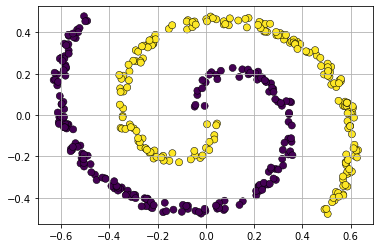

In [6]:
%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)
plt.grid()
plt.savefig("./invex_out/classification_1_invex.pdf", bbox_inches='tight')

In [6]:
xx = np.column_stack((x1, x2))
inp = torch.tensor(xx, dtype=torch.float32)
yy = torch.tensor(y, dtype=torch.float32).reshape(-1,1)

In [7]:
## for db image plotting
n = 200
x_, y_ = np.meshgrid(np.linspace(xx[:,0].min(), xx[:,0].max(), n), np.linspace(xx[:,1].min(), xx[:,1].max(), n))
xx_img = np.c_[x_.ravel(), y_.ravel()]
xx_img = torch.FloatTensor(xx_img)

v = np.linspace(0.0, 1.0, 11, endpoint=True)

In [8]:
# network_seed = 147  # 147 #258 # 369
# network_seeds = [147, 258, 369]
network_seeds = [369]

EPOCHS = 5000

actf = nn.LeakyReLU
# actf = nn.ELU

learning_rate = 0.005
lambda_ = 2

criterion = nn.BCELoss()

In [9]:
from classes import *

# Logistic Regression

Epoch: 0, Loss:0.7426194548606873, Acc:50.0, Norm: 0.22194935381412506
Epoch: 100, Loss:0.6426562666893005, Acc:69.75, Norm: 0.7390923500061035
Epoch: 200, Loss:0.596062958240509, Acc:70.75, Norm: 1.3221796751022339
Epoch: 300, Loss:0.5670351982116699, Acc:71.75, Norm: 1.836050033569336
Epoch: 400, Loss:0.5476868152618408, Acc:72.0, Norm: 2.2787704467773438
Epoch: 500, Loss:0.5349606871604919, Acc:72.0, Norm: 2.655421257019043
Epoch: 600, Loss:0.5267200469970703, Acc:72.0, Norm: 2.9726274013519287
Epoch: 700, Loss:0.5214712619781494, Acc:72.0, Norm: 3.237149238586426
Epoch: 800, Loss:0.5181897878646851, Acc:72.5, Norm: 3.45542573928833
Epoch: 900, Loss:0.5161817669868469, Acc:72.5, Norm: 3.6334266662597656
Epoch: 1000, Loss:0.5149829983711243, Acc:72.5, Norm: 3.7766575813293457
Epoch: 1100, Loss:0.5142871737480164, Acc:72.5, Norm: 3.8901877403259277
Epoch: 1200, Loss:0.5138958692550659, Acc:72.0, Norm: 3.9786646366119385
Epoch: 1300, Loss:0.5136833786964417, Acc:72.0, Norm: 4.046338558

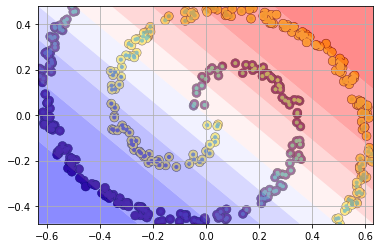

In [10]:
%matplotlib tk
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

epoch_times = []
stat_per_seed = []
images = []
for network_seed in network_seeds:
    torch.manual_seed(network_seed)

    logNet = LogisticRegression(2)
    optimizer = torch.optim.Adam(logNet.parameters(), lr=learning_rate)

    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = logNet(inp)    
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
            print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, Norm: {float(torch.norm(logNet.linear.weight.data))}')
            ax.clear()
            ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
            ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')

            yout_img = logNet(xx_img)
            out = yout_img.data.numpy().astype(float)
            cf = ax.contourf(x_, y_, out.reshape(x_.shape), v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
            ax.grid()

            fig.canvas.draw()
            plt.pause(0.01)
    stat_per_seed.append(
        f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, Norm: {float(torch.norm(logNet.linear.weight.data))}'
    )
    
#     image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)\
#                         .reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     images.append(image_from_plot)

    plt.savefig("./invex_out/comparision/cls_logistic.pdf", bbox_inches='tight')

In [11]:
# %matplotlib inline
# fig = plt.figure(figsize=(8,6))
# plt.contourf(x_, y_, out.reshape(x_.shape),
#              v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
# plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
# plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
# plt.grid()

%matplotlib inline
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()

for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

Epoch: 4999, Loss:0.5134696960449219, Acc:72.0, Norm: 4.213048458099365
0.000596689748764038 0.0005445771610148386


# Convex NN

Epoch: 0, Loss:2.2844676971435547, Acc:50.0
Epoch: 100, Loss:0.5493165850639343, Acc:70.5
Epoch: 200, Loss:0.5012121796607971, Acc:72.25
Epoch: 300, Loss:0.4530526101589203, Acc:73.5
Epoch: 400, Loss:0.4133215844631195, Acc:81.0
Epoch: 500, Loss:0.39321228861808777, Acc:82.75
Epoch: 600, Loss:0.3851359188556671, Acc:83.0
Epoch: 700, Loss:0.38114264607429504, Acc:83.0
Epoch: 800, Loss:0.37913817167282104, Acc:82.75
Epoch: 900, Loss:0.37803971767425537, Acc:82.75
Epoch: 1000, Loss:0.3774288594722748, Acc:82.75
Epoch: 1100, Loss:0.3769439458847046, Acc:83.0
Epoch: 1200, Loss:0.3766149580478668, Acc:83.0
Epoch: 1300, Loss:0.37638619542121887, Acc:82.75
Epoch: 1400, Loss:0.37641414999961853, Acc:82.75
Epoch: 1500, Loss:0.3759315609931946, Acc:83.0
Epoch: 1600, Loss:0.3757701814174652, Acc:82.75
Epoch: 1700, Loss:0.3755606710910797, Acc:83.0
Epoch: 1800, Loss:0.37542811036109924, Acc:83.0
Epoch: 1900, Loss:0.3752993047237396, Acc:83.0
Epoch: 2000, Loss:0.3752089738845825, Acc:83.0
Epoch: 210

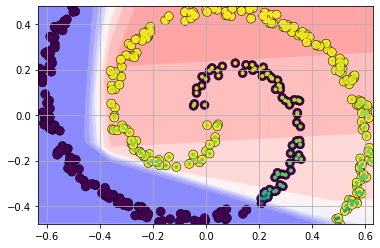

In [12]:
%matplotlib tk
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

epoch_times = []
stat_per_seed = []
images = []
for network_seed in network_seeds:
    torch.manual_seed(network_seed)

    cvxNet = ConvexNN([2,100,100,1], actf)
    sigmoid = nn.Sigmoid()
    optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = sigmoid(-cvxNet(inp))    
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
            print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}')
            ax.clear()
            yout_img = sigmoid(-cvxNet(xx_img))
            # out = (yout_img.data.numpy()>0.5).astype(int)
            out = yout_img.data.numpy().astype(float)
            cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
            ax.grid()

            ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
            ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')

            fig.canvas.draw()
            plt.pause(0.01)
    stat_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}')
    
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)\
                        .reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image_from_plot)
    
    plt.savefig("./invex_out/comparision/cls_convex.pdf", bbox_inches='tight')

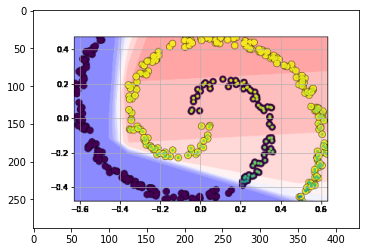

Epoch: 4999, Loss:0.37372279167175293, Acc:82.25
0.0029979887962341308 0.000617899390503235


In [13]:
# %matplotlib inline
# fig = plt.figure(figsize=(8,6))
# plt.contourf(x_, y_, out.reshape(x_.shape),
#              v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
# plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
# plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
# plt.grid()

%matplotlib inline
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()

for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

# Single Layer NN

Epoch: 0, Loss:0.6938124895095825, Acc:44.0
Epoch: 100, Loss:0.0283243115991354, Acc:99.0
Epoch: 200, Loss:0.0055352021008729935, Acc:100.0
Epoch: 300, Loss:0.0011550576891750097, Acc:100.0
Epoch: 400, Loss:0.00030666013481095433, Acc:100.0
Epoch: 500, Loss:0.00010439506877446547, Acc:100.0
Epoch: 600, Loss:5.123102164361626e-05, Acc:100.0
Epoch: 700, Loss:3.0421071642194875e-05, Acc:100.0
Epoch: 800, Loss:2.012687036767602e-05, Acc:100.0
Epoch: 900, Loss:1.4288351849245373e-05, Acc:100.0
Epoch: 1000, Loss:1.0654533980414271e-05, Acc:100.0
Epoch: 1100, Loss:8.23775462777121e-06, Acc:100.0
Epoch: 1200, Loss:6.539577043440659e-06, Acc:100.0
Epoch: 1300, Loss:5.3040489547129255e-06, Acc:100.0
Epoch: 1400, Loss:4.3824811655213125e-06, Acc:100.0
Epoch: 1500, Loss:3.6733370052388636e-06, Acc:100.0
Epoch: 1600, Loss:3.1172776289167814e-06, Acc:100.0
Epoch: 1700, Loss:2.6728580451162998e-06, Acc:100.0
Epoch: 1800, Loss:2.3104150841390947e-06, Acc:100.0
Epoch: 1900, Loss:2.0144448171777185e-06,

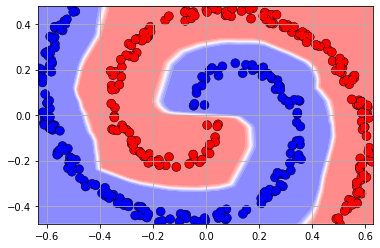

In [14]:
%matplotlib tk
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

epoch_times = []
stat_per_seed = []
images = []
for network_seed in network_seeds:
    torch.manual_seed(network_seed)

    mlpNet = nn.Sequential(nn.Linear(2,100),
                             actf(),
                             nn.Linear(100,100),
                             actf(),
                             nn.Linear(100,1),
                             nn.Sigmoid()
                            )
    optimizer = torch.optim.Adam(mlpNet.parameters(), lr=learning_rate)
    
    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = mlpNet(inp)
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
            print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}')
            yout_img = mlpNet(xx_img)
            # out = (yout_img.data.numpy()>0.5).astype(int)
            out = yout_img.data.numpy().astype(float)
            ax.clear()
            cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
            ax.grid()
            ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
            ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)

            fig.canvas.draw()
            plt.pause(0.01)
            
    stat_per_seed.append(
        f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}'
    )
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)\
                        .reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image_from_plot)
    plt.savefig("./invex_out/comparision/cls_nn.pdf", bbox_inches='tight')

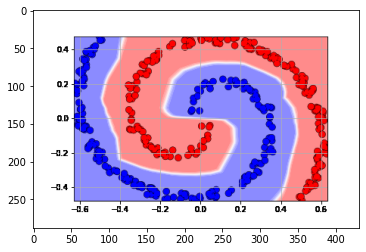

Epoch: 4999, Loss:1.3053460179435206e-07, Acc:100.0
0.002105210018157959 0.0005415342014902506


In [15]:
# %matplotlib inline
# fig = plt.figure(figsize=(8,6))
# plt.contourf(x_, y_, out.reshape(x_.shape),
#              v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
# plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
# plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
# plt.grid()

%matplotlib inline
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()

for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

# Invex

In [16]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

In [17]:
class BasicInvexNet(nn.Module):
    
    def __init__(self, input_dim, net, lamda=1.):
        super().__init__()
        
        self.net = net
        self.center = nn.Parameter(torch.zeros(input_dim).unsqueeze(0))
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx_cent = None
        self.dydx = None
        
        self.gp = 0
        self.gclipper = 999
        
    def forward(self, x, hook=True):
#         self.weight_norm()
        self.X = x
        if not x.requires_grad:
            self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        if y.requires_grad and hook:
            y.register_hook(self.scale_gradient_back)
        return y
    
    def scale_gradient_back(self, grad):
        return torch.minimum(torch.maximum(grad, -self.gclipper), self.gclipper)
    
    def weight_norm(self):
        for child in get_children(self.net):
            if isinstance(child, nn.Linear):
                norm = torch.norm(child.weight.data, dim=1)
#                 print(norm)
                indx = torch.nonzero(norm>5., as_tuple=False).t()[0]
                if len(indx)==0: continue
#                 print(indx)
#                 print("Weight")
#                 print(child.weight.data[indx].shape)
                child.weight.data[indx] *= 3/(norm[indx].reshape(-1,1))
        
    def get_dydx_cent(self):
        self.dydx_cent = self.center-self.X.data
        self.dydx_cent = self.dydx_cent/torch.norm(self.dydx_cent, p=2, dim=1, keepdim=True)
        return self.dydx_cent
    
    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def smooth_l1(self, x, beta=1):
        mask = x<beta
        y = torch.empty_like(x)
        y[mask] = 0.5*(x[mask]**2)/beta
        y[~mask] = torch.abs(x[~mask])-0.5*beta
        return y
    
    def get_gradient_penalty(self):
        m = self.dydx.shape[0]
        ## gradient is projected in the direction of center (aka. minima/maxima)
        projected_grad = torch.bmm(self.dydx.view(m, 1, -1), self.dydx_cent.view(m, -1, 1)).view(-1, 1)
        self.cond = projected_grad
        
        a=-20
#         intolerables = torch.log(torch.exp(a*(self.cond-0.1))+1)/a
#         intolerables = torch.clamp(F.softplus(self.cond-0.1, beta=-20), -1, 1)
        intolerables = F.softplus(self.cond-0.1, beta=-20)

#         dydx_norm = torch.norm(self.dydx.data, p=2, dim=1, keepdim=True)
#         self.gp = 0.5*((intolerables*5)**2).mean()*self.lamda
        
        self.gp = (self.smooth_l1(intolerables*5)).mean()*self.lamda

        return self.gp
    
    def get_gradient_clipper(self):
        with torch.no_grad():
            cond = self.cond.data
            linear_mask = cond>0.14845
            a = 20.
            gclipper = -((1.05*(cond-1))**4)+1
            gclipper = torch.log(torch.exp(a*gclipper)+1)/a
            gc2 = 3*cond-0.0844560006
            gclipper[linear_mask] = gc2[linear_mask]
            self.gclipper = gclipper
        return self.gclipper

    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty_and_clipper(self):
        self.get_dydx_cent()
        self.get_dydx()
        self.get_gradient_penalty()
        self.get_gradient_clipper()
        return

In [18]:
# torch.manual_seed(network_seed)

# net_lips = nn.Sequential(nn.Linear(2,100),
#                          actf(),
#                          nn.Linear(100,100),
#                          actf(),
#                          nn.Linear(100,1),
#                         )
# sigmoid = nn.Sigmoid()

# lcNet = BasicInvexNet(2, net_lips, lamda=lambda_)
# optimizer = torch.optim.Adam(lcNet.parameters(), lr=learning_rate)

In [49]:
%matplotlib tk
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

epoch_times = []
stat_per_seed = []
images = []
# for network_seed in network_seeds:
for network_seed in [369]:
    torch.manual_seed(network_seed)
    
    net_lips = nn.Sequential(nn.Linear(2,100),
                             actf(),
                             nn.Linear(100,100),
                             actf(),
                             nn.Linear(100,1),
                            )
    sigmoid = nn.Sigmoid()
    lcNet = BasicInvexNet(2, net_lips, lamda=lambda_)
    optimizer = torch.optim.Adam(lcNet.parameters(), lr=learning_rate)
    
    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = sigmoid(lcNet(inp))    
        lcNet.compute_penalty_and_clipper()
        loss = criterion(yout, yy) + lcNet.gp

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = float(loss-lcNet.gp)

        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
            min_val = float(lcNet.cond.min()) 
            print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
            ax.clear()

            yout_img = sigmoid(lcNet(xx_img))
            # out = (yout_img.data.numpy()>0.5).astype(int)
            out = yout_img.data.numpy().astype(float)
            cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
            ax.grid()
            ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
            ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)

            fig.canvas.draw()
            plt.pause(0.01)
        
    stat_per_seed.append(
        f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}'
    )
    
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)\
                        .reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image_from_plot)
#     plt.savefig("./invex_out/comparision/cls_basic_invex.pdf", bbox_inches='tight')

Epoch: 0, Loss:1.1849292516708374, Acc:44.0, MinVal:-0.09014855325222015, gp: 0.49111679196357727
Epoch: 100, Loss:0.5710695385932922, Acc:70.75, MinVal:-0.1994606852531433, gp: 0.03808588907122612
Epoch: 200, Loss:0.3956810235977173, Acc:76.25, MinVal:0.9323701858520508, gp: 1.396141390658719e-18
Epoch: 300, Loss:0.29384905099868774, Acc:81.25, MinVal:0.03888911008834839, gp: 0.0008102221763692796
Epoch: 400, Loss:0.2615180015563965, Acc:82.0, MinVal:0.05392861366271973, gp: 0.0005235350108705461
Epoch: 500, Loss:0.23148493468761444, Acc:84.5, MinVal:0.06401169300079346, gp: 0.00039925239980220795
Epoch: 600, Loss:0.17505261301994324, Acc:88.0, MinVal:-0.027196526527404785, gp: 0.0017510466277599335
Epoch: 700, Loss:0.15609966218471527, Acc:89.25, MinVal:-0.028325557708740234, gp: 0.0012999725295230746
Epoch: 800, Loss:0.14990220963954926, Acc:89.75, MinVal:0.03368997573852539, gp: 0.000405829370720312
Epoch: 900, Loss:0.13965284824371338, Acc:91.0, MinVal:-0.058777570724487305, gp: 0

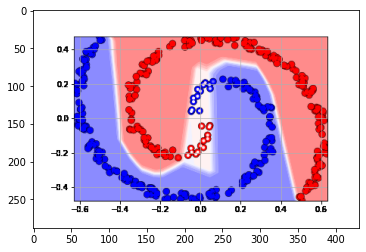

Epoch: 4999, Loss:0.04426680505275726, Acc:96.5, MinVal:0.14172685146331787, gp: 0.00012656203762162477
0.005470335245132446 0.0009554908111122026


In [20]:
# %matplotlib inline
# fig = plt.figure(figsize=(8,6))
# plt.contourf(x_, y_, out.reshape(x_.shape),
#              v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
# plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
# plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
# plt.grid()

%matplotlib inline
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()

for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

In [21]:
# to break the code

# Multiple Invex 

In [ ]:
# torch.manual_seed(network_seed)
    
#     net_lips = nn.Sequential(nn.Linear(2,100),
#                              actf(),
#                              nn.Linear(100,100),
#                              actf(),
#                              nn.Linear(100,1),
#                             )
#     sigmoid = nn.Sigmoid()
#     lcNet = BasicInvexNet(2, net_lips, lamda=lambda_)
#     optimizer = torch.optim.Adam(lcNet.parameters(), lr=learning_rate)
    
#     for epoch in range(EPOCHS):
#         start = time.time()
        
#         yout = sigmoid(lcNet(inp))    
#         lcNet.compute_penalty_and_clipper()
#         loss = criterion(yout, yy) + lcNet.gp

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_times.append(time.time()-start)
#         if epoch%100 == 0 or epoch==EPOCHS-1:
#             acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
#             min_val = float(lcNet.cond.min()) 
#             print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
#             ax.clear()

#             yout_img = sigmoid(lcNet(xx_img))
#             # out = (yout_img.data.numpy()>0.5).astype(int)
#             out = yout_img.data.numpy().astype(float)
#             cf = ax.contourf(x_, y_, out.reshape(x_.shape),
#                              v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
#             ax.grid()
#             ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
#             ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)

#             fig.canvas.draw()
#             plt.pause(0.01)
    

In [50]:
network_seed = 369
torch.manual_seed(network_seed)

net_invx = nn.Sequential(nn.Linear(2,100),
                             actf(),
                             nn.Linear(100,100),
                             actf(),
                             nn.Linear(100,1),
                            )
lcNet = BasicInvexNet(2, net_invx, lamda=lambda_)

In [46]:
net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
liNet = LipschitzInvexNet(lcNet, net_lips, lamda=lambda_)

sigmoid = nn.Sigmoid()
optimizer = torch.optim.Adam(lcNet.parameters(), lr=learning_rate)

In [51]:
use_mixup = False
use_check = True
check_every = 2
check_size = 500
m_,s_ = (inp.max(0,True)[0] - inp.min(0,True)[0]), inp.min(0,True)[0]

In [52]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(EPOCHS):
    
    if use_mixup:
        rand_indx = np.random.permutation(len(inp))
        rand_lambda = torch.rand(len(inp), 1)*0.1
        x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
        y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    else:
        x_mix = inp
        y_mix = yy
    
    yout = sigmoid(lcNet(inp))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + lcNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    
    loss = float(loss-lcNet.gp)
    
    if use_check and epoch%check_every == 0:
        rand_inp = torch.rand(check_size, 2)*m_+s_
        lcNet(rand_inp)
        lcNet.compute_penalty_and_clipper()
        lcNet.gp.backward(retain_graph=True)
        
    optimizer.step()
    if epoch%100 == 0 or epoch==EPOCHS-1:
        yout = sigmoid(lcNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:1.1849292516708374, Acc:50.0, MinVal:-0.10987217724323273, gp: 0.46627166867256165
Epoch: 100, Loss:0.5603923201560974, Acc:70.25, MinVal:-0.22985902428627014, gp: 0.010689216665923595
Epoch: 200, Loss:0.3930965065956116, Acc:82.5, MinVal:-0.32817432284355164, gp: 0.020052647218108177
Epoch: 300, Loss:0.36567753553390503, Acc:83.25, MinVal:-0.2498301863670349, gp: 0.006132066249847412
Epoch: 400, Loss:0.3419162929058075, Acc:80.0, MinVal:-0.037454813718795776, gp: 0.001065456192009151
Epoch: 500, Loss:0.3133113980293274, Acc:84.25, MinVal:-0.13480739295482635, gp: 0.00732040498405695
Epoch: 600, Loss:0.2767281234264374, Acc:87.0, MinVal:-0.040417127311229706, gp: 0.0011018834775313735
Epoch: 700, Loss:0.24096481502056122, Acc:89.5, MinVal:0.13329066336154938, gp: 6.786717131035402e-05
Epoch: 800, Loss:0.2004716694355011, Acc:90.5, MinVal:-0.23016929626464844, gp: 0.00582999037578702
Epoch: 900, Loss:0.17391961812973022, Acc:91.0, MinVal:0.19364821910858154, gp: 5.7863253

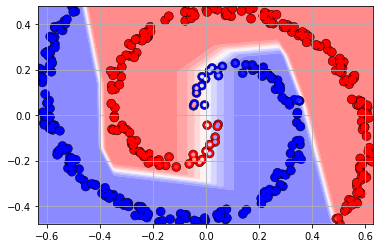

In [40]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

plt.savefig("./invex_out/comparision/cls_invex_0.pdf", bbox_inches='tight')


## Freeze initial invex func

In [27]:
optimizer = torch.optim.Adam(net_lips.parameters(), lr=learning_rate)

In [28]:
use_mixup = False
use_check = False
check_every = 2
check_size = 500

m_,s_ = (inp.max(0,True)[0] - inp.min(0,True)[0]), inp.min(0,True)[0]

Epoch: 0, Loss:0.05244026705622673, Acc:96.5, MinVal:8.15373420715332, gp: 0.0
Epoch: 100, Loss:0.00318983499892056, Acc:100.0, MinVal:1.0305194854736328, gp: 2.140101875636367e-20
Epoch: 200, Loss:0.0015482638264074922, Acc:100.0, MinVal:6.651805877685547, gp: 0.0
Epoch: 300, Loss:0.0005045018042437732, Acc:100.0, MinVal:0.2501506805419922, gp: 1.1001013717759633e-06
Epoch: 400, Loss:0.0002360113721806556, Acc:100.0, MinVal:0.2897930145263672, gp: 1.542204586257867e-07
Epoch: 500, Loss:0.00042401495738886297, Acc:100.0, MinVal:11.020462036132812, gp: 0.0
Epoch: 600, Loss:0.00022828493092674762, Acc:100.0, MinVal:6.96861457824707, gp: 0.0
Epoch: 700, Loss:0.0001589734893059358, Acc:100.0, MinVal:3.0601863861083984, gp: 0.0
Epoch: 800, Loss:0.00011981517309322953, Acc:100.0, MinVal:0.38289546966552734, gp: 1.8963084436052213e-09
Epoch: 900, Loss:9.477829735260457e-05, Acc:100.0, MinVal:0.3542647361755371, gp: 5.944412517777664e-09
Epoch: 1000, Loss:7.712897058809176e-05, Acc:100.0, MinV

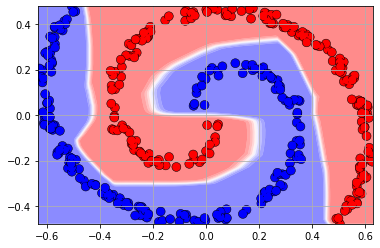

In [29]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(EPOCHS):
    
    if use_mixup:
        rand_indx = np.random.permutation(len(inp))
        rand_lambda = torch.rand(len(inp), 1)*0.1
        x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
        y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    else:
        x_mix = inp
        y_mix = yy
    
    yout = sigmoid(liNet(inp)) 
    lcNet.get_dydx()
    liNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + liNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    
    loss = float(loss-liNet.gp)
    
    if use_check and epoch%check_every == 0:
        rand_inp = torch.rand(check_size, 2)*m_+s_
        liNet(rand_inp)
        lcNet.get_dydx()
        liNet.compute_penalty_and_clipper()
        liNet.gp.backward(retain_graph=True)
        
    optimizer.step()
    if epoch%100 == 0 or epoch==EPOCHS-1:
        yout = sigmoid(liNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

tensor(100.)


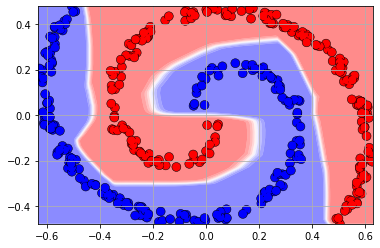

In [30]:
%matplotlib inline

yout = sigmoid(liNet(inp))
acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
out = sigmoid(liNet(xx_img)).data.numpy().astype(float)

print(acc)

fig = plt.figure(figsize=(6,4))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

plt.savefig("./invex_out/comparision/cls_invex_1.pdf", bbox_inches='tight')

### No freezing previous invex

In [44]:
network_seed = 369
torch.manual_seed(network_seed)

net_invx = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
lcNet = BasicInvexNet(2, net_invx, lamda=lambda_)

In [32]:
net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
liNet = LipschitzInvexNet(lcNet, net_lips, lamda=lambda_)
sigmoid = nn.Sigmoid()
optimizer = torch.optim.Adam(liNet.parameters(), lr=learning_rate)

In [33]:
use_mixup = False
use_check = False
check_every = 2
check_size = 500

m_,s_ = (inp.max(0,True)[0] - inp.min(0,True)[0]), inp.min(0,True)[0]

Epoch: 0, Loss:1.3816287517547607, Acc:48.25, MinVal:-0.08354859054088593, gp: 0.19172994792461395
	 InvxNet; MinVal:-0.09014855325222015, gp: 0.49111679196357727
Epoch: 100, Loss:0.5252386331558228, Acc:77.5, MinVal:-0.07672366499900818, gp: 0.01969181001186371
	 InvxNet; MinVal:-0.10126537829637527, gp: 0.03884490206837654
Epoch: 200, Loss:0.4116324782371521, Acc:82.25, MinVal:0.18174633383750916, gp: 7.049452960927738e-06
	 InvxNet; MinVal:-0.12307465076446533, gp: 0.011329586617648602
Epoch: 300, Loss:0.42038649320602417, Acc:82.25, MinVal:0.23336853086948395, gp: 2.4599819880677387e-05
	 InvxNet; MinVal:-0.17346544563770294, gp: 0.03285945951938629
Epoch: 400, Loss:0.39245229959487915, Acc:82.5, MinVal:0.7350701093673706, gp: 7.701356371202228e-14
	 InvxNet; MinVal:-0.19541968405246735, gp: 0.011918412521481514
Epoch: 500, Loss:0.3677371144294739, Acc:83.0, MinVal:0.4457038342952728, gp: 8.278355778656987e-09
	 InvxNet; MinVal:0.12287110090255737, gp: 0.00014501705300062895
Epoch:

Epoch: 4999, Loss:0.03589249029755592, Acc:99.5, MinVal:0.06465435028076172, gp: 0.0004415824369061738
	 InvxNet; MinVal:0.08644133806228638, gp: 0.00017090252367779613


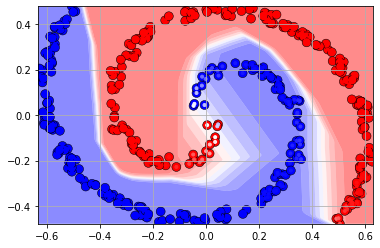

In [34]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(EPOCHS):
    
    if use_mixup:
        rand_indx = np.random.permutation(len(inp))
        rand_lambda = torch.rand(len(inp), 1)*0.1
        x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
        y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    else:
        x_mix = inp
        y_mix = yy
    
    yout = sigmoid(liNet(inp)) 
    lcNet.compute_penalty_and_clipper()
    liNet.compute_penalty_and_clipper()
    
    optimizer.zero_grad()
    loss = criterion(yout, y_mix) 
    loss += liNet.gp 
    loss += lcNet.gp
    loss.backward(retain_graph=True)
    
    if use_check and epoch%check_every == 0:
        rand_inp = torch.rand(check_size, 2)*m_+s_
        liNet(rand_inp, True)
        lcNet.compute_penalty_and_clipper()
        liNet.compute_penalty_and_clipper()
        (lcNet.gp+liNet.gp).backward(retain_graph=True)
        
    optimizer.step()
    if epoch%100 == 0 or epoch==EPOCHS-1:
        yout = sigmoid(liNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        print(f'\t InvxNet; MinVal:{lcNet.cond.min()}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

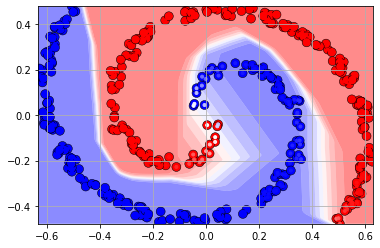

In [35]:
%matplotlib inline
# fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(6,4))

plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
yout = sigmoid(liNet(inp))
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

plt.savefig("./invex_out/comparision/cls_invex_both.pdf", bbox_inches='tight')